In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

from random import shuffle
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchvision import transforms


In [3]:
torch.cuda.is_available()

True

## Import data from dirs

In [4]:
def get_train_valid_data(base_dir, file_format=".jpg", valid_size=0.25):
    dirs_inside = {}  # class - index dict
    for index, dir_name in enumerate(os.listdir(base_dir)):
        # add only directories inside
        if os.path.isdir(os.path.join(base_dir, dir_name)):
            dirs_inside[dir_name] = float(index)
            
    print(f'Found {len(dirs_inside.keys())} classes')
    # create train and validate lists for images paths
    train_data_x, train_data_y = [], []
    valid_data_x, valid_data_y = [], []
    
    for sub_dir in dirs_inside.keys():
        # get all images inside directory
        class_data = glob(os.path.join(base_dir, sub_dir) + f"\\*{file_format}", recursive=True) 
        # get count samples for training set
        class_samples_train = int(len(class_data) * (1 - valid_size))
        print(f'Found {len(class_data)} images for {sub_dir}')
        
        train_data_x += class_data[:class_samples_train]    
        valid_data_x += class_data[class_samples_train:]
    # shuffle data
    shuffle(train_data_x)
    shuffle(valid_data_x)
    # set labels
    train_data_y = [dirs_inside[file.split('\\')[1]] for file in train_data_x]
    valid_data_y = [dirs_inside[file.split('\\')[1]] for file in valid_data_x] 
    
    print(f"Train size is {len(train_data_x)}, validation size is {len(valid_data_x)}")
    return train_data_x, train_data_y, valid_data_x, valid_data_y

In [5]:
data_folder = "internship_data"
train_x, train_y, valid_x, valid_y = get_train_valid_data(base_dir=data_folder)

Found 2 classes
Found 50001 images for female
Found 50001 images for male
Train size is 75000, validation size is 25002


In [16]:
class MyImageDataset(Dataset):
    """Create pytorch iterable Dataset to generate images with X paths
    params:
        X[list] - list of paths for images
        Y[list] - list of labels for X
        img_size (int) - size of output images. Default 156
        transform_compose (torchvision.transforms.Compose) - transforms for output images. 
            Default: transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor(),])
    """
    def __init__(self, X, Y, base_dir, img_size=156, transform_compose=None):
        self.files = X
        self.classes = Y
        self.size = img_size
        self.transforms = transforms.Compose([transforms.Resize((img_size, img_size)), 
                                              transforms.ToTensor(),]) if transform_compose is None else transform_compose  
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, key):
        # get image by path with index=key
        pillow_img = Image.open(self.files[key])
        # apply transforms to image
        x = self.transforms(pillow_img)
        y = self.classes[key]
        return x, y

In [ ]:
def validate_model(model, data_loader, num_samples=100, cuda_model=True):
    predictions, real_classes = [], []
    for sample_index, (xb, yb) in enumerate(data_loader):
        with torch.no_grad():
            if cuda_model:
                preds = vgg_model(xb.cuda())
            else:
                preds = vgg_model(xb)
                
        predictions.append(torch.argmax(preds.cpu()).item())
        real_classes.append(yb.item())
        if sample_index == num_samples:
            break
            
    predictions = np.array(predictions, dtype=int)
    real_classes = np.array(real_classes, dtype=int)
    print("accuracy is", np.mean((predictions==real_classes).astype(float)) )
    return predictions, real_classes

### Create VGG model

In [7]:
from torchvision.models import vgg16

def set_parameter_requires_grad(model, feature_extracting):
    """Seting model parameters not trainable"""
    if feature_extracting:
        for param in model.features.parameters():
            param.requires_grad = False
            
def get_vgg_model(num_classes, path='vgg16_model.pt', feature_extracting=True):
    """Get vgg model with fixed parameters if feature_extracting = True.
    params:
        num_classes (int): count of outputs for model
        feature_extracting (bool): sets models parameters not trainable
    returns: model, input_image_size
    """
    input_size = 224  # input size for vgg pretrained model
    model = torch.load(path)  # my default path
    set_parameter_requires_grad(model, feature_extracting=True)
    
    num_features = model.classifier[6].in_features  # size of input for 6-nd fc layer
    features = list(model.classifier.children())[:-1] # remove last layer
    features.extend([nn.Linear(num_features, num_classes)]) # add new layer with new num_classes
    model.classifier = nn.Sequential(*features) # replace the model classifier

    return model, input_size

In [34]:
# clear cuda cache
torch.cuda.empty_cache()

In [9]:
# get model
vgg_model, img_size = get_vgg_model(num_classes=2, feature_extracting=True)
# load to gpu
vgg_model.cuda()
optimizer_vgg = torch.optim.Adam(vgg_model.parameters(), lr=1e-3)
loss_function_vgg = nn.CrossEntropyLoss()  # classification loss

In [17]:
# use standart transforms with normalization and without augmentation
vgg_transforms = transforms.Compose([transforms.Resize((img_size, img_size)), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create dataset
train_ds_vgg = MyImageDataset(train_x, train_y, base_dir=data_folder, img_size=img_size, transform_compose=vgg_transforms)
valid_ds_vgg = MyImageDataset(valid_x, valid_y, base_dir=data_folder, img_size=img_size, transform_compose=vgg_transforms)
# create pytorch batch loaders
vgg_dl_train = DataLoader(train_ds_vgg, batch_size=32, shuffle=True, drop_last=True)
vgg_dl_valid = DataLoader(valid_ds_vgg)

### Create new simple CNN

In [32]:
class CNN_Net(nn.Module):
    
    def __init__(self, input_channels=3, output_size=1):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=428, kernel_size=3)
        
        self.fc1 = nn.Linear(428*3*3, 1024)  # sizes from c5
        self.fc2 = nn.Linear(1024, 128)
        self.out = nn.Linear(128, output_size)
        
        self.flatten_size = None
    
    def forward(self, x):
        c1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        c2 = F.max_pool2d(F.relu(self.conv2(c1)), (2, 2))
        c3 = F.max_pool2d(F.relu(self.conv3(c2)), (2, 2))
        c4 = F.max_pool2d(F.relu(self.conv4(c3)), (2, 2))
        c5 = F.max_pool2d(F.relu(self.conv5(c4)), (2, 2))
        
        if self.flatten_size is None:
            self.flatten_size = c5.shape[1] * c5.shape[2] * c5.shape[3]
            
        c5 = c5.view(-1, self.flatten_size)
        f1 = F.relu(self.fc1(c5))
        f2 = F.relu(self.fc2(f1))
        out = self.out(f2)
        return out

In [35]:
model = CNN_Net(output_size=2)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

In [36]:
IMG_SIZE = 156
train_ds = MyImageDataset(train_x, train_y, base_dir=data_folder, img_size=IMG_SIZE)
valid_ds = MyImageDataset(valid_x, valid_y, base_dir=data_folder, img_size=IMG_SIZE)

tensor_dl_train = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=False)
tensor_dl_valid = DataLoader(valid_ds, pin_memory=False)

## 1. Train model

In [12]:
def accuracy(pred_tensor, target):
    pred_classes = torch.argmax(pred_tensor, dim=1)
    equal_classes = (pred_classes == target).float()
    return torch.mean(equal_classes)

In [37]:
def train(model, epochs, optimizer, loss_func, train_loader, valid_loader=None, train_frac=1.):
    # create history for each epoch list for metrics
    train_history = [[], []]
    valid_history = [[], []]
    for ep in range(epochs):
        # history for current epoch
        ep_train_loss, ep_train_acc = [], []
        for i, (xb, yb) in enumerate(train_loader):
            optimizer.zero_grad()
            # pass to gpu
            yb = yb.long().cuda()
            # get predictions
            preds = model(xb.cuda())
            # calculate loss
            loss = loss_func(preds, yb)
            # backpropagation
            loss.backward()
            optimizer.step()
            
            # calculate metrics for batch
            acc = accuracy(preds, yb).item()
            ep_train_acc.append(acc)
            ep_train_loss.append(loss.item())
            
            if i % 100 == 0:
                print(f'Batch {i+1}. Accuracy={acc:.5}, Loss={loss.item()}')
            
            if i / len(train_loader) >= train_frac:
                break
            
        # mean accuracy and loss for current epoch
        train_history[0].append(np.array(ep_train_acc).mean())
        train_history[1].append(np.array(ep_train_loss).mean())
        
        if valid_loader is not None:
            with torch.no_grad():
                eval_acc, eval_loss = [], []
                for xb, yb in valid_loader:
                    preds = model(xb.cuda())
                    eval_loss.append(loss_func(preds, yb.float().cuda()).item())
                    eval_acc.append(accuracy(preds, yb.float().cuda()).item())
                # mean accuracy and loss for current epoch with validation data
                valid_history[0].append(np.array(eval_acc).mean())
                valid_history[1].append(np.array(eval_loss).mean())
        
        print(f'Epoch {ep}. acc:', round(np.array(ep_train_acc).mean(), 5), 'loss:', round(np.array(ep_train_loss).mean(), 5))
    
    return train_history, valid_history

### 1.1 Train model VGG

In [18]:
train_hist, valid_hist = train(vgg_model, epochs=5, optimizer=optimizer_vgg, loss_func=loss_function_vgg, train_loader=vgg_dl_train, valid_loader=None, train_frac=0.5) # 

Batch 1. Accuracy=0.34375, Loss=0.778610110282898
Batch 11. Accuracy=0.875, Loss=0.42155393958091736
Batch 21. Accuracy=0.75, Loss=1.410356044769287
Batch 31. Accuracy=0.78125, Loss=0.9105362296104431
Batch 41. Accuracy=0.9375, Loss=0.3288538157939911
Batch 51. Accuracy=0.90625, Loss=0.22524712979793549
Batch 61. Accuracy=0.875, Loss=0.2616981863975525
Batch 71. Accuracy=0.96875, Loss=0.19793248176574707
Batch 81. Accuracy=0.875, Loss=0.3303065299987793
Batch 91. Accuracy=0.90625, Loss=0.23510144650936127
Batch 101. Accuracy=1.0, Loss=0.05649895220994949
Batch 111. Accuracy=0.96875, Loss=0.16274334490299225
Batch 121. Accuracy=0.875, Loss=0.2142927050590515
Batch 131. Accuracy=0.875, Loss=0.31840959191322327
Batch 141. Accuracy=0.8125, Loss=0.5947136282920837
Batch 151. Accuracy=0.9375, Loss=0.2503553032875061
Batch 161. Accuracy=0.84375, Loss=0.4410962760448456
Batch 171. Accuracy=0.96875, Loss=0.12755605578422546
Batch 181. Accuracy=0.71875, Loss=0.6765922904014587
Batch 191. Accurac

Batch 381. Accuracy=0.9375, Loss=0.2713235020637512
Batch 391. Accuracy=0.96875, Loss=0.5432876348495483
Batch 401. Accuracy=0.875, Loss=0.22043998539447784
Batch 411. Accuracy=1.0, Loss=0.09387548267841339
Batch 421. Accuracy=0.9375, Loss=0.2902231514453888
Batch 431. Accuracy=0.9375, Loss=0.24864014983177185
Batch 441. Accuracy=0.9375, Loss=0.12991860508918762
Batch 451. Accuracy=0.84375, Loss=0.245723158121109
Batch 461. Accuracy=0.9375, Loss=0.19979076087474823
Batch 471. Accuracy=0.9375, Loss=0.12286727130413055
Batch 481. Accuracy=0.9375, Loss=0.357485294342041
Batch 491. Accuracy=0.90625, Loss=0.3562089800834656
Batch 501. Accuracy=0.90625, Loss=0.1700412482023239
Batch 511. Accuracy=0.90625, Loss=0.3442966341972351
Batch 521. Accuracy=0.9375, Loss=0.1900239884853363
Batch 531. Accuracy=0.96875, Loss=0.11628502607345581
Batch 541. Accuracy=0.96875, Loss=0.08531434088945389
Batch 551. Accuracy=0.9375, Loss=0.07039805501699448
Batch 561. Accuracy=0.875, Loss=0.14452996850013733
Ba

Batch 751. Accuracy=0.84375, Loss=0.36383309960365295
Batch 761. Accuracy=0.9375, Loss=0.1682513952255249
Batch 771. Accuracy=0.9375, Loss=0.32951316237449646
Batch 781. Accuracy=0.90625, Loss=0.15319421887397766
Batch 791. Accuracy=0.90625, Loss=0.4933803975582123
Batch 801. Accuracy=0.96875, Loss=0.12514157593250275
Batch 811. Accuracy=0.90625, Loss=0.28702470660209656
Batch 821. Accuracy=0.90625, Loss=0.31932714581489563
Batch 831. Accuracy=0.90625, Loss=0.12134409695863724
Batch 841. Accuracy=0.875, Loss=0.5898645520210266
Batch 851. Accuracy=1.0, Loss=0.08306997269392014
Batch 861. Accuracy=1.0, Loss=0.013880658894777298
Batch 871. Accuracy=1.0, Loss=0.05010552331805229
Batch 881. Accuracy=0.96875, Loss=0.09323794394731522
Batch 891. Accuracy=0.96875, Loss=0.06133805587887764
Batch 901. Accuracy=0.96875, Loss=0.024368425831198692
Batch 911. Accuracy=0.96875, Loss=0.1599598377943039
Batch 921. Accuracy=0.9375, Loss=0.10676269233226776
Batch 931. Accuracy=1.0, Loss=0.015654990449547

Batch 1121. Accuracy=0.96875, Loss=0.08099852502346039
Batch 1131. Accuracy=0.9375, Loss=0.12007370591163635
Batch 1141. Accuracy=0.90625, Loss=0.1264885663986206
Batch 1151. Accuracy=1.0, Loss=0.0424153208732605
Batch 1161. Accuracy=0.90625, Loss=0.1301383227109909
Batch 1171. Accuracy=0.96875, Loss=0.047750312834978104
Epoch 3. acc: 0.94208 loss: 0.18906
Batch 1. Accuracy=1.0, Loss=0.05123085901141167
Batch 11. Accuracy=0.96875, Loss=0.10530781000852585
Batch 21. Accuracy=0.90625, Loss=0.12931247055530548
Batch 31. Accuracy=0.9375, Loss=0.23939409852027893
Batch 41. Accuracy=0.96875, Loss=0.0854935497045517
Batch 51. Accuracy=0.96875, Loss=0.060197614133358
Batch 61. Accuracy=0.96875, Loss=0.09009959548711777
Batch 71. Accuracy=0.9375, Loss=0.08540253341197968
Batch 81. Accuracy=0.9375, Loss=0.14173181354999542
Batch 91. Accuracy=0.96875, Loss=0.04846572503447533
Batch 101. Accuracy=0.96875, Loss=0.22440248727798462
Batch 111. Accuracy=0.90625, Loss=0.2047707587480545
Batch 121. Accu

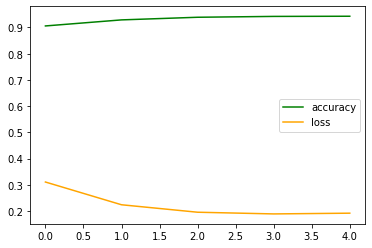

In [19]:
plt.plot(train_hist[0], color='green', label='accuracy')
plt.plot(train_hist[1], color='orange', label='loss')
plt.legend()
plt.show()

In [23]:
preds, real = validate_model(vgg_model, vgg_dl_valid, num_samples=5000)

accuracy is 0.9262147570485902


### 1.2 Train simple CNN model

In [38]:
train_hist_cnn, valid_hist_cnn = train(model, epochs=10, optimizer=optimizer, loss_func=loss_function, train_loader=tensor_dl_train, valid_loader=None, train_frac=0.3) # 

torch.Size([32, 428, 3, 3]) 3852
Batch 1. Accuracy=0.53125, Loss=0.6928560733795166
Batch 101. Accuracy=0.34375, Loss=0.7169457077980042
Batch 201. Accuracy=0.5, Loss=0.692734956741333
Batch 301. Accuracy=0.65625, Loss=0.6896031498908997
Batch 401. Accuracy=0.59375, Loss=0.6610868573188782
Batch 501. Accuracy=0.625, Loss=0.6847348809242249
Batch 601. Accuracy=0.65625, Loss=0.6011820435523987
Batch 701. Accuracy=0.71875, Loss=0.5437538027763367
Epoch 0. acc: 0.62793 loss: 0.62057
Batch 1. Accuracy=0.78125, Loss=0.5079799890518188
Batch 101. Accuracy=0.875, Loss=0.2762523889541626
Batch 201. Accuracy=0.84375, Loss=0.37937843799591064
Batch 301. Accuracy=0.75, Loss=0.5214934945106506
Batch 401. Accuracy=0.8125, Loss=0.35650864243507385
Batch 501. Accuracy=0.84375, Loss=0.39418888092041016
Batch 601. Accuracy=0.875, Loss=0.34674209356307983
Batch 701. Accuracy=0.90625, Loss=0.263385146856308
Epoch 1. acc: 0.84251 loss: 0.37466
Batch 1. Accuracy=0.84375, Loss=0.252165287733078
Batch 101. Ac

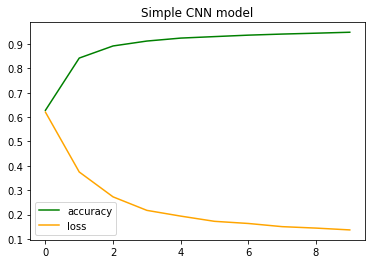

In [39]:
plt.plot(train_hist_cnn[0], color='green', label='accuracy')
plt.plot(train_hist_cnn[1], color='orange', label='loss')
plt.title("Simple CNN model")
plt.legend()
plt.show()

#### Saving models

In [42]:
torch.save(vgg_model, 'vgg_model_trained.pt')

In [43]:
torch.save(vgg_model, 'my_model_trained.pt')